## Textbook input signals

To generally see how a system output behaves in time, there are two standard signals we like to use:
1. the Dirac-delta impulse signal
2. and the (Heaviside) step signal.

The impulse signal is primarily used to see the transient behaviour of the system and the step functions shows the transient and steady state behaviour. Look at these plots to see! We're even able to seperate the transient from the steady state for the step!

<IPython.core.display.Javascript object>

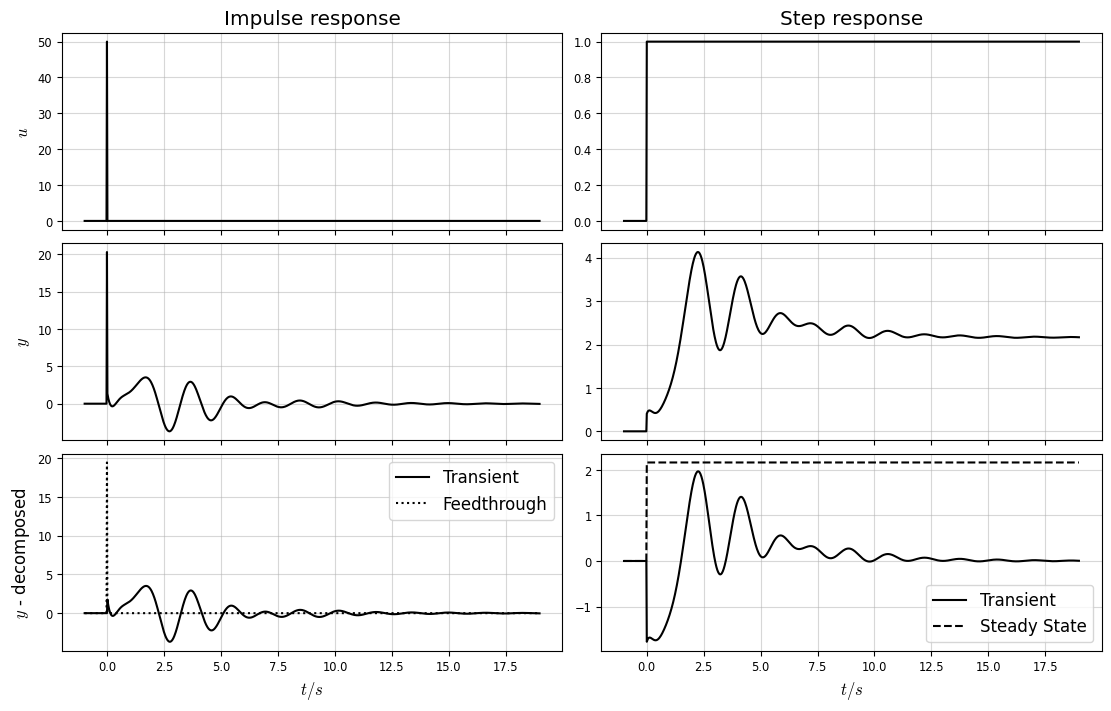

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

import scipy.linalg as sclin
import numpy.random as rng
import numpy.linalg as lin
import control as cm
from helperFunctions import *
setPlotStyle()

# Create random system
P_res = cm.rss(20)
P_res.D = [rng.rand()]

T_res = np.arange(1000)*0.02 - 1.

## impulse response
impIn = np.zeros_like(T_res)
impIn[int(-T_res[0]/(T_res[1] - T_res[0]))] = 1./(T_res[1] - T_res[0])
impResponse = cm.forced_response(P_res,
                                 T = T_res,
                                 U = impIn)

impTrans = np.full(len(impResponse.time), np.nan)
impTrans = np.array([(P_res.C@sclin.expm(P_res.A*t)@P_res.B)[0][0] for t in impResponse.time])
impTrans[impResponse.time<0] = 0.0

## step response
stpIn = np.zeros_like(T_res)
stpIn[T_res >= 0] = 1.
stpResponse = cm.forced_response(P_res,
                                 T = T_res,
                                 U = stpIn)

stpTrans = np.zeros_like(T_res)
stpTrans[stpResponse.time >= 0] = np.array([(P_res.C@lin.inv(P_res.A)@sclin.expm(P_res.A*t)@P_res.B)[0][0] 
                        for t in stpResponse.time[stpResponse.time >= 0]])
stpStead = np.zeros_like(T_res)
stpStead[stpResponse.time >= 0] = (P_res.D - P_res.C@lin.inv(P_res.A)@P_res.B)[0][0]

####### Plotting #######
fig, ax = plt.subplots(3,2, sharex='col', figsize=[11, 7])

ax[0,0].set(title="Impulse response", ylabel="$u$")
ax[1,0].set(ylabel="$y$")
ax[2,0].set(xlabel="$t/s$", ylabel="$y$ - decomposed")
ax[0,0].plot(impResponse.time, impResponse.inputs, 'k')
ax[1,0].plot(impResponse.time, impResponse.outputs, 'k')
l1, = ax[2,0].plot(impResponse.time, impTrans, 'k', label="Transient")
l2, = ax[2,0].plot(impResponse.time, np.squeeze(P_res.D*impResponse.inputs), 'k:', label="Feedthrough")
ax[2,0].legend(handles=[l1,l2])

ax[0,1].set(title="Step response")
ax[2,1].set(xlabel="$t / s$")
ax[0,1].plot(stpResponse.time, stpResponse.inputs, 'k')
ax[1,1].plot(stpResponse.time, stpResponse.outputs, 'k')
l1, = ax[2,1].plot(stpResponse.time, stpTrans, 'k', label="Transient")
l2, = ax[2,1].plot(stpResponse.time, stpStead, 'k--', label="Steady State")
ax[2,1].legend(handles=[l1,l2])
display(fig)


Decomposing a signal into a transient and steady state part? How is that possible? It really comes down to seperating the time dependent and time independent parts. Remember the closed trajectory expression
$$ x(t) = e^{At}x_0 + \int_0^t e^{A(t-\tau)}Bu(\tau)d\tau$$
and
$$ y(t) = Cx(t) + Du(t) = Ce^{At}x_0 + \int_0^t Ce^{A(t-\tau)}Bu(\tau)d\tau + Du(t).$$

Now assuming $x_0 =0$, and substituting the respective input time-signals yields the solutions
$$ y_\text{impulse}(t) = \underbrace{Ce^{At}B}_\text{Transient} + \underbrace{D\delta(t)}_\text{Feedthrough}$$
and
$$ y_\text{step}(t) = \underbrace{CA^{-1}e^{At}B}_\text{Transient} + \underbrace{D - CA^{-1}B}_\text{Steady State}.$$
Tada, we've decomposed the signal!